In [1]:
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
dataset_path = 'C:/Users/91882/Desktop/Intership work/yolor/train/train'

In [45]:
countries = ['Japan','India','Czech']

In [46]:
xml_list = []

for i in countries:
    path = dataset_path+'/'+i+'/annotations/xmls'
    for file in os.listdir(path):
        xml_list.append(path+'/'+file)

In [47]:
len(xml_list)

21041

In [48]:
xml_list[0]

'C:/Users/91882/Desktop/Intership work/yolor/train/train/Japan/annotations/xmls/Japan_000000.xml'

In [3]:
dest_path = 'C:/Users/91882/Desktop/Intership work/yolor/xml_annotations_corrected_classes/'

In [50]:
def classes_remover(dest_path, xml_list):
  '''
  This function takes xml file and convert it into a another xml file with same file name, but these new files can have only 4 possible damage types,
  namely D00, D10, D20 and D40
  Input : xml file destination path (string), xml file name (string)
  '''
  for each_xml_file in xml_list:
    # parse the file using ElementTree module
    tree = ET.parse(each_xml_file)
    # get the parsed xml data in tree like format
    root = tree.getroot()
    # create a list of objects 
    raw_root = [o for o in root.iter('object')]
    # iterate over the above list to check the class name 
    for obj in raw_root:
        # get the text inside the 'name' tag i.e. our class label
        cls_name = obj.find('name').text
        # if the class label is not in the "D00,D10,D20,D40" remove the object tag elemet
        if cls_name not in "D00,D10,D20,D40".split(","):
            root.remove(obj)

    tree = ET.ElementTree(root)

    file_name = each_xml_file.split('/')[-1]
    new_file_path = dest_path + file_name
    tree.write(new_file_path, encoding="utf-8")
    tree = ET.parse(new_file_path)
    with open(new_file_path, 'r') as f: 
        data = f.read()

In [51]:
classes_remover(dest_path,xml_list)

#### Converting the Annotations into the YOLO Format

In [52]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [325]:
info_dict_eg = extract_info_from_xml('C:/Users/91882/Desktop/Intership work/yolor/xml_annotations_corrected_classes/India_000596.xml')

In [326]:
print(info_dict_eg)

{'bboxes': [{'class': 'D40', 'xmin': 233, 'ymin': 538, 'xmax': 354, 'ymax': 609}, {'class': 'D20', 'xmin': 300, 'ymin': 487, 'xmax': 691, 'ymax': 716}], 'filename': 'India_000596.jpg', 'image_size': (3, 720, 720)}


In [328]:
info_dict_eg['image_size'][0]

3

#### Classes: Longitudinal Cracks(D00), Transverse Cracks(D10), Alligator Cracks(D20) and Potholes(D40)

In [5]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"D00": 0,
                           "D10": 1,
                           "D20": 2,
                           "D40": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h = max(info_dict['image_size']),max(info_dict['image_size'])
            
            
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("C://Users//91882//Desktop//Intership work//yolor//yolo_annotations", info_dict["filename"][:-3]+'txt')
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [330]:
# Get the annotations
annotations = [os.path.join('C://Users//91882//Desktop//Intership work//yolor//xml_annotations_corrected_classes', x) for x in os.listdir('C://Users//91882//Desktop//Intership work//yolor//xml_annotations_corrected_classes') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

100%|███████████████████████████████████████████████████████████████████████████| 21041/21041 [01:40<00:00, 209.49it/s]


#### Testing the annotations

In [331]:
annotations = [os.path.join('C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations', x) for x in os.listdir('C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations') if x[-3:] == "txt"]

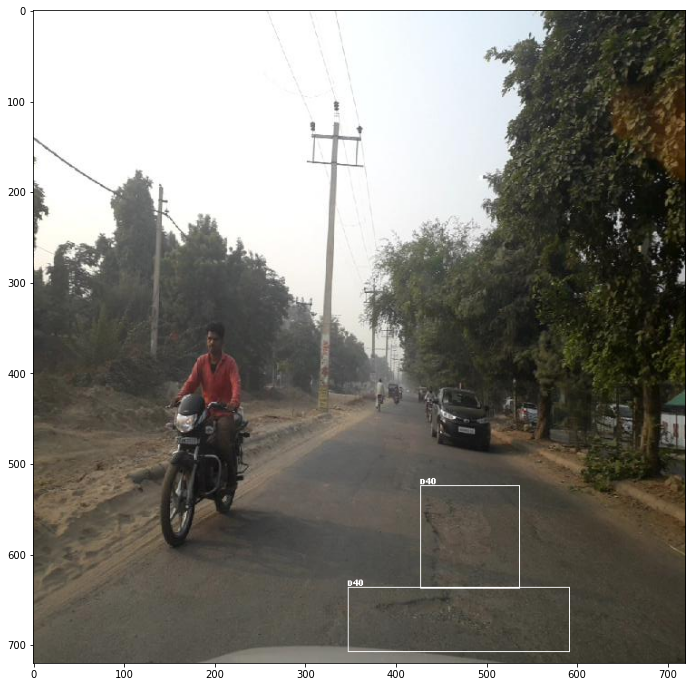

In [335]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    figure(figsize=(12, 12))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations\\India_000718.txt'

with open(annotation_file, "r") as file:
    annotation_list_1 = file.read().split("\n")[:-1]
    annotation_list_2 = [x.split(" ") for x in annotation_list_1]
    annotation_list=[]
    for lis in annotation_list_2:
        annotation_list.append(list(np.float_(lis)))
#Get the corresponding image file
image_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\train\\train\\India\\images\\India_000718.jpg'
#assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [333]:
annotation_list

[[3.0, 0.408, 0.797, 0.168, 0.099], [2.0, 0.688, 0.835, 0.543, 0.318]]

In [ ]:
# 000718 #000596

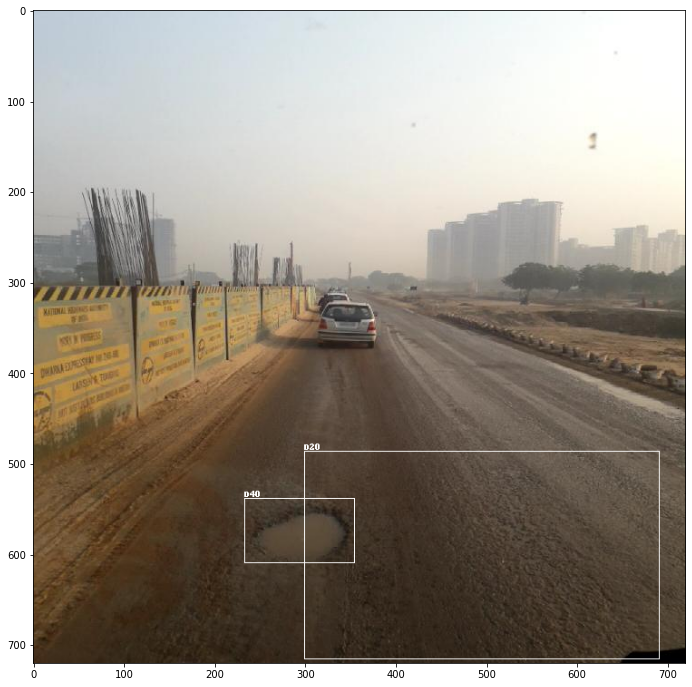

In [6]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    figure(figsize=(12, 12))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations\\India_000596.txt'

with open(annotation_file, "r") as file:
    annotation_list_1 = file.read().split("\n")[:-1]
    annotation_list_2 = [x.split(" ") for x in annotation_list_1]
    annotation_list=[]
    for lis in annotation_list_2:
        annotation_list.append(list(np.float_(lis)))
#Get the corresponding image file
image_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\train\\train\\India\\images\\India_000596.jpg'
#assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

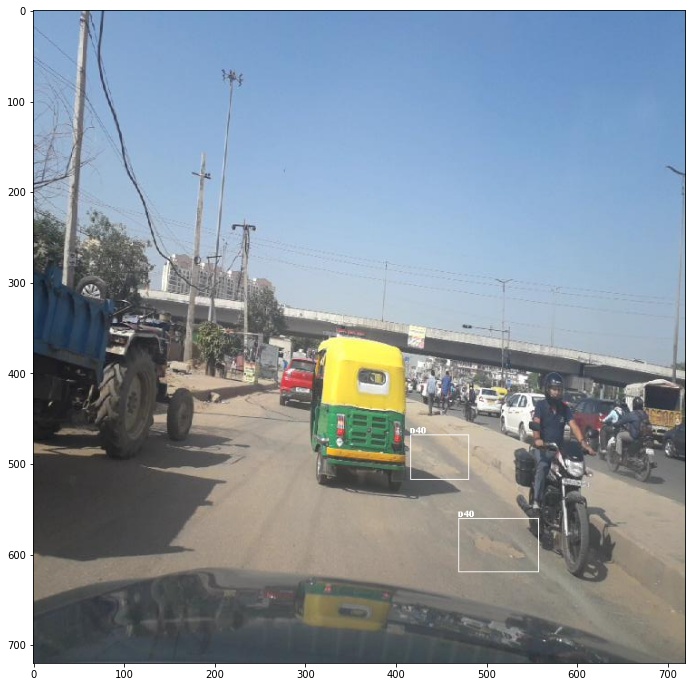

In [7]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    figure(figsize=(12, 12))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations\\India_000822.txt'

with open(annotation_file, "r") as file:
    annotation_list_1 = file.read().split("\n")[:-1]
    annotation_list_2 = [x.split(" ") for x in annotation_list_1]
    annotation_list=[]
    for lis in annotation_list_2:
        annotation_list.append(list(np.float_(lis)))
#Get the corresponding image file
image_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\train\\train\\India\\images\\India_000822.jpg'
#assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [10]:
random.seed(10)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    figure(figsize=(12, 12))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\yolo_annotations\\India_002165.txt'

with open(annotation_file, "r") as file:
    annotation_list_1 = file.read().split("\n")[:-1]
    annotation_list_2 = [x.split(" ") for x in annotation_list_1]
    annotation_list=[]
    for lis in annotation_list_2:
        annotation_list.append(list(np.float_(lis)))
#Get the corresponding image file
image_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\train\\train\\India\\images\\India_002165.jpg'
#assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

ValueError: could not convert string to float: 

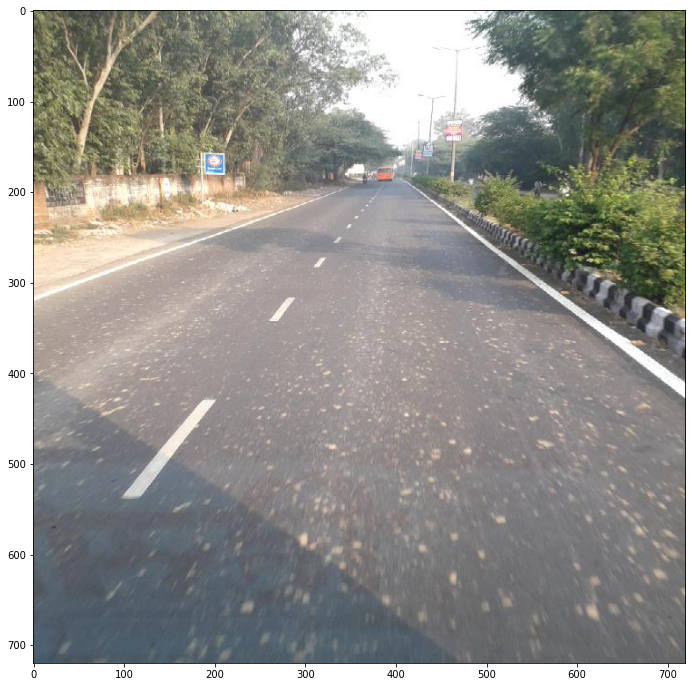

In [11]:
image_file = 'C:\\Users\\91882\\Desktop\\Intership work\\yolor\\train\\train\\India\\images\\India_002165.jpg'
image = Image.open(image_file)
figure(figsize=(12, 12))
plt.imshow(np.array(image))
plt.show()